In [1]:
!git clone https://github.com/pwu-dev/deep-learning-project.git

Cloning into 'deep-learning-project'...
remote: Enumerating objects: 3079, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 3079 (delta 42), reused 157 (delta 33), pack-reused 2906
Receiving objects: 100% (3079/3079), 1.06 GiB | 16.70 MiB/s, done.
Resolving deltas: 100% (566/566), done.
Updating files: 100% (1993/1993), done.


Fonction de chargement des images

In [2]:
import os
import PIL
from PIL import Image
import numpy as np

def load_data(data_path, classes, split="training", image_size=128):

	num_images = 0
	for i in range(len(classes)):
		dirs = sorted(os.listdir(data_path + '/' + split + '/' + classes[i]))
		num_images += len(dirs)
                                
	x = np.zeros((num_images, image_size, image_size, 3))
	y = np.zeros((num_images, 1))
    
	current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
	for idx_class in range(len(classes)):
		dirs = sorted(os.listdir(data_path + '/' + split + '/' + classes[idx_class]))
		num_images += len(dirs)
    
        # Chargement des images, 
		for idx_img in range(len(dirs)):
			item = dirs[idx_img]
			if os.path.isfile(data_path + '/' + split + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
				img = Image.open(data_path + '/' + split + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
				img = img.convert('RGB')

        # Redimensionnement de l'image et écriture dans la variable de retour x 
				img = img.resize((image_size,image_size))
				x[current_index] = np.asarray(img)/255
                # Écriture du label associé dans la variable de retour y
				y[current_index] = idx_class
				current_index += 1

	return x, y

Variables utiles

In [3]:
path = "./deep-learning-project/dataset"
CLASSES = ["beurre", "cremes-dessert", "eaux", "fromages", "haricots-verts", 
           "huiles-cuisson", "jus-fruits", "lait", "mais", "oeufs", 
           "pates", "petits-pois", "poissons", "riz", "sodas", 
           "soupes", "viandes-rouges", "volailles", "yaourts-laitiers"]

CLASSES = ["beurre", "cremes-dessert", "eaux", "fromages", "haricots-verts", "huiles-cuisson", "jus-fruits", "mais", "oeufs", "pates", "petits-pois", "riz", "sodas", "soupes", "volailles", "yaourts-laitiers"]

IMAGE_SIZE = 128

Chargement des images

In [7]:
x_training, y_training = load_data(path, CLASSES, split="entrainement", image_size=IMAGE_SIZE)
shuffle_indices = np.random.permutation(x_training.shape[0])
x_training = x_training[shuffle_indices]
y_training = y_training[shuffle_indices]

x_validation, y_validation = load_data(path, CLASSES, split="validation", image_size=IMAGE_SIZE)
shuffle_indices = np.random.permutation(x_validation.shape[0])
x_validation = x_validation[shuffle_indices]
y_validation = y_validation[shuffle_indices]

x_test, y_test = load_data(path, CLASSES, split="tests", image_size=IMAGE_SIZE)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
for i in range(0, 9):
	plt.subplot(3, 3, i+1)
	image = x_validation[i]
	plt.title(CLASSES[int(y_validation[i])])
	plt.imshow(image)

plt.tight_layout()
plt.show()

In [ ]:
%load_ext tensorboard

Création du model

In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import json

HP_NUM_UNITS = hp.HParam("hidden_layer", hp.Discrete([512, 1024]))
HP_NUM_FILTERS = hp.HParam("num_conv", hp.Discrete(["[32, 64, 96, 128]", "[32, 64, 128, 256]"]))
HP_FILTER_SIZE = hp.HParam("filter_size", hp.Discrete([3, 5]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.1, 0.1))

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_NUM_FILTERS, HP_FILTER_SIZE, HP_DROPOUT],
    metrics=[hp.Metric("sparse_categorical_accuracy", display_name="Accuracy")]
  )

def createModel(hparams, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    filters = json.loads(hparams[HP_NUM_FILTERS])
    for i, filter in enumerate(filters):
      if i == 0:
        conv = tf.keras.layers.Conv2D(filter, hparams[HP_FILTER_SIZE], activation="relu")(input_layer)
        dropout = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(conv)
        pool = tf.keras.layers.MaxPooling2D()(dropout)
      else:
        conv = tf.keras.layers.Conv2D(filter, hparams[HP_FILTER_SIZE], activation="relu")(pool)
        dropout = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(conv)
        pool = tf.keras.layers.MaxPooling2D()(dropout)

    output = tf.keras.layers.Flatten()(pool)
    output = tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu")(output)
    output = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(output)
    output = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(output)

    model = tf.keras.models.Model(input_layer, output)

    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"],
    )

    return model


def run(run_dir, hparams, fit_function):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    model = createModel(hparams)
    accuracy = fit_function(model)
    tf.summary.scalar("sparse_categorical_accuracy", accuracy, step=1)

In [ ]:
def default_training(model):
  model.fit(x_training, y_training, 
              validation_data=(x_validation, y_validation), 
              epochs=10, 
              batch_size=10
              )
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [ ]:
import tensorflow as tf
import shutil

def generate_logs(fit_function):
  session_num = 0
  shutil.rmtree("logs")

  for num_units in HP_NUM_UNITS.domain.values:
    for num_filters in HP_NUM_FILTERS.domain.values:
      for filter_size in HP_FILTER_SIZE.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_NUM_FILTERS: num_filters,
              HP_FILTER_SIZE: filter_size,
              HP_DROPOUT: dropout_rate
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams, fit_function)
          session_num += 1

In [ ]:
generate_logs(default_training)
%tensorboard --logdir logs/hparam_tuning

Ancienne méthode

In [ ]:
history = model.fit(x_training, y_training, validation_data=(x_validation, y_validation), epochs=10, batch_size=10)

import matplotlib.pyplot as plt

def plot_training_analysis():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_training_analysis()

Augmentation de données

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


In [ ]:
import tensorflow as tf

def augmented_data_training(model):
  model.fit(train_datagen.flow(x_training, y_training, batch_size=16),
              validation_data=(x_validation, y_validation), 
              epochs=50
              )
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [ ]:
generate_logs(augmented_data_training)
%tensorboard --logdir logs/hparam_tuning

--- Starting trial: run-0
{'hidden_layer': 512, 'num_conv': '[32, 64, 128, 256]', 'filter_size': 3, 'dropout': 0.1}
Epoch 1/50
81/81 [==============================] - 10s 84ms/step - loss: 2.7377 - sparse_categorical_accuracy: 0.0874 - val_loss: 2.6435 - val_sparse_categorical_accuracy: 0.1312
Epoch 2/50
81/81 [==============================] - 7s 92ms/step - loss: 2.6373 - sparse_categorical_accuracy: 0.1230 - val_loss: 2.5960 - val_sparse_categorical_accuracy: 0.1562
Epoch 3/50
81/81 [==============================] - 6s 77ms/step - loss: 2.5756 - sparse_categorical_accuracy: 0.1485 - val_loss: 2.4918 - val_sparse_categorical_accuracy: 0.2438
Epoch 4/50
81/81 [==============================] - 7s 92ms/step - loss: 2.3818 - sparse_categorical_accuracy: 0.2328 - val_loss: 2.1659 - val_sparse_categorical_accuracy: 0.3688
Epoch 5/50
37/81 [============>.................] - ETA: 3s - loss: 2.2387 - sparse_categorical_accuracy: 0.2699

KeyboardInterrupt: ignored

Transfert Learning


In [14]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

conv_base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [16]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax'))

conv_base.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_training, y_training, batch_size=16), 
                    validation_data=(x_validation, y_validation),
                    epochs=50,
                    )

Epoch 1/50
81/81 [==============================] - 18s 112ms/step - loss: 2.4112 - sparse_categorical_accuracy: 0.2529 - val_loss: 1.6608 - val_sparse_categorical_accuracy: 0.5688
Epoch 2/50
81/81 [==============================] - 5s 67ms/step - loss: 1.7678 - sparse_categorical_accuracy: 0.4602 - val_loss: 1.3653 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/50
81/81 [==============================] - 6s 78ms/step - loss: 1.4723 - sparse_categorical_accuracy: 0.5507 - val_loss: 1.0935 - val_sparse_categorical_accuracy: 0.6250
Epoch 4/50
81/81 [==============================] - 5s 67ms/step - loss: 1.2988 - sparse_categorical_accuracy: 0.5940 - val_loss: 0.9814 - val_sparse_categorical_accuracy: 0.6938
Epoch 5/50
81/81 [==============================] - 6s 76ms/step - loss: 1.1402 - sparse_categorical_accuracy: 0.6543 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.7312
Epoch 6/50
81/81 [==============================] - 6s 73ms/step - loss: 1.0368 - sparse_categorical_ac

In [ ]:
conv_base.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-8),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_training, y_training, batch_size=16), 
                    validation_data=(x_validation, y_validation),
                    epochs=50,
                    )

Epoch 1/50
81/81 [==============================] - 19s 134ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.6824 - val_sparse_categorical_accuracy: 0.7937
Epoch 2/50
81/81 [==============================] - 10s 124ms/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.7937
Epoch 3/50
81/81 [==============================] - 9s 108ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.8062
Epoch 4/50
81/81 [==============================] - 9s 112ms/step - loss: 0.2242 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.6738 - val_sparse_categorical_accuracy: 0.8000
Epoch 5/50
81/81 [==============================] - 8s 102ms/step - loss: 0.2070 - sparse_categorical_accuracy: 0.9404 - val_loss: 0.6732 - val_sparse_categorical_accuracy: 0.8000
Epoch 6/50
81/81 [==============================] - 9s 110ms/step - loss: 0.1946 - sparse_categori

In [ ]:
plot_training_analysis()

NameError: ignored

5/5 [==============================] - 0s 55ms/step


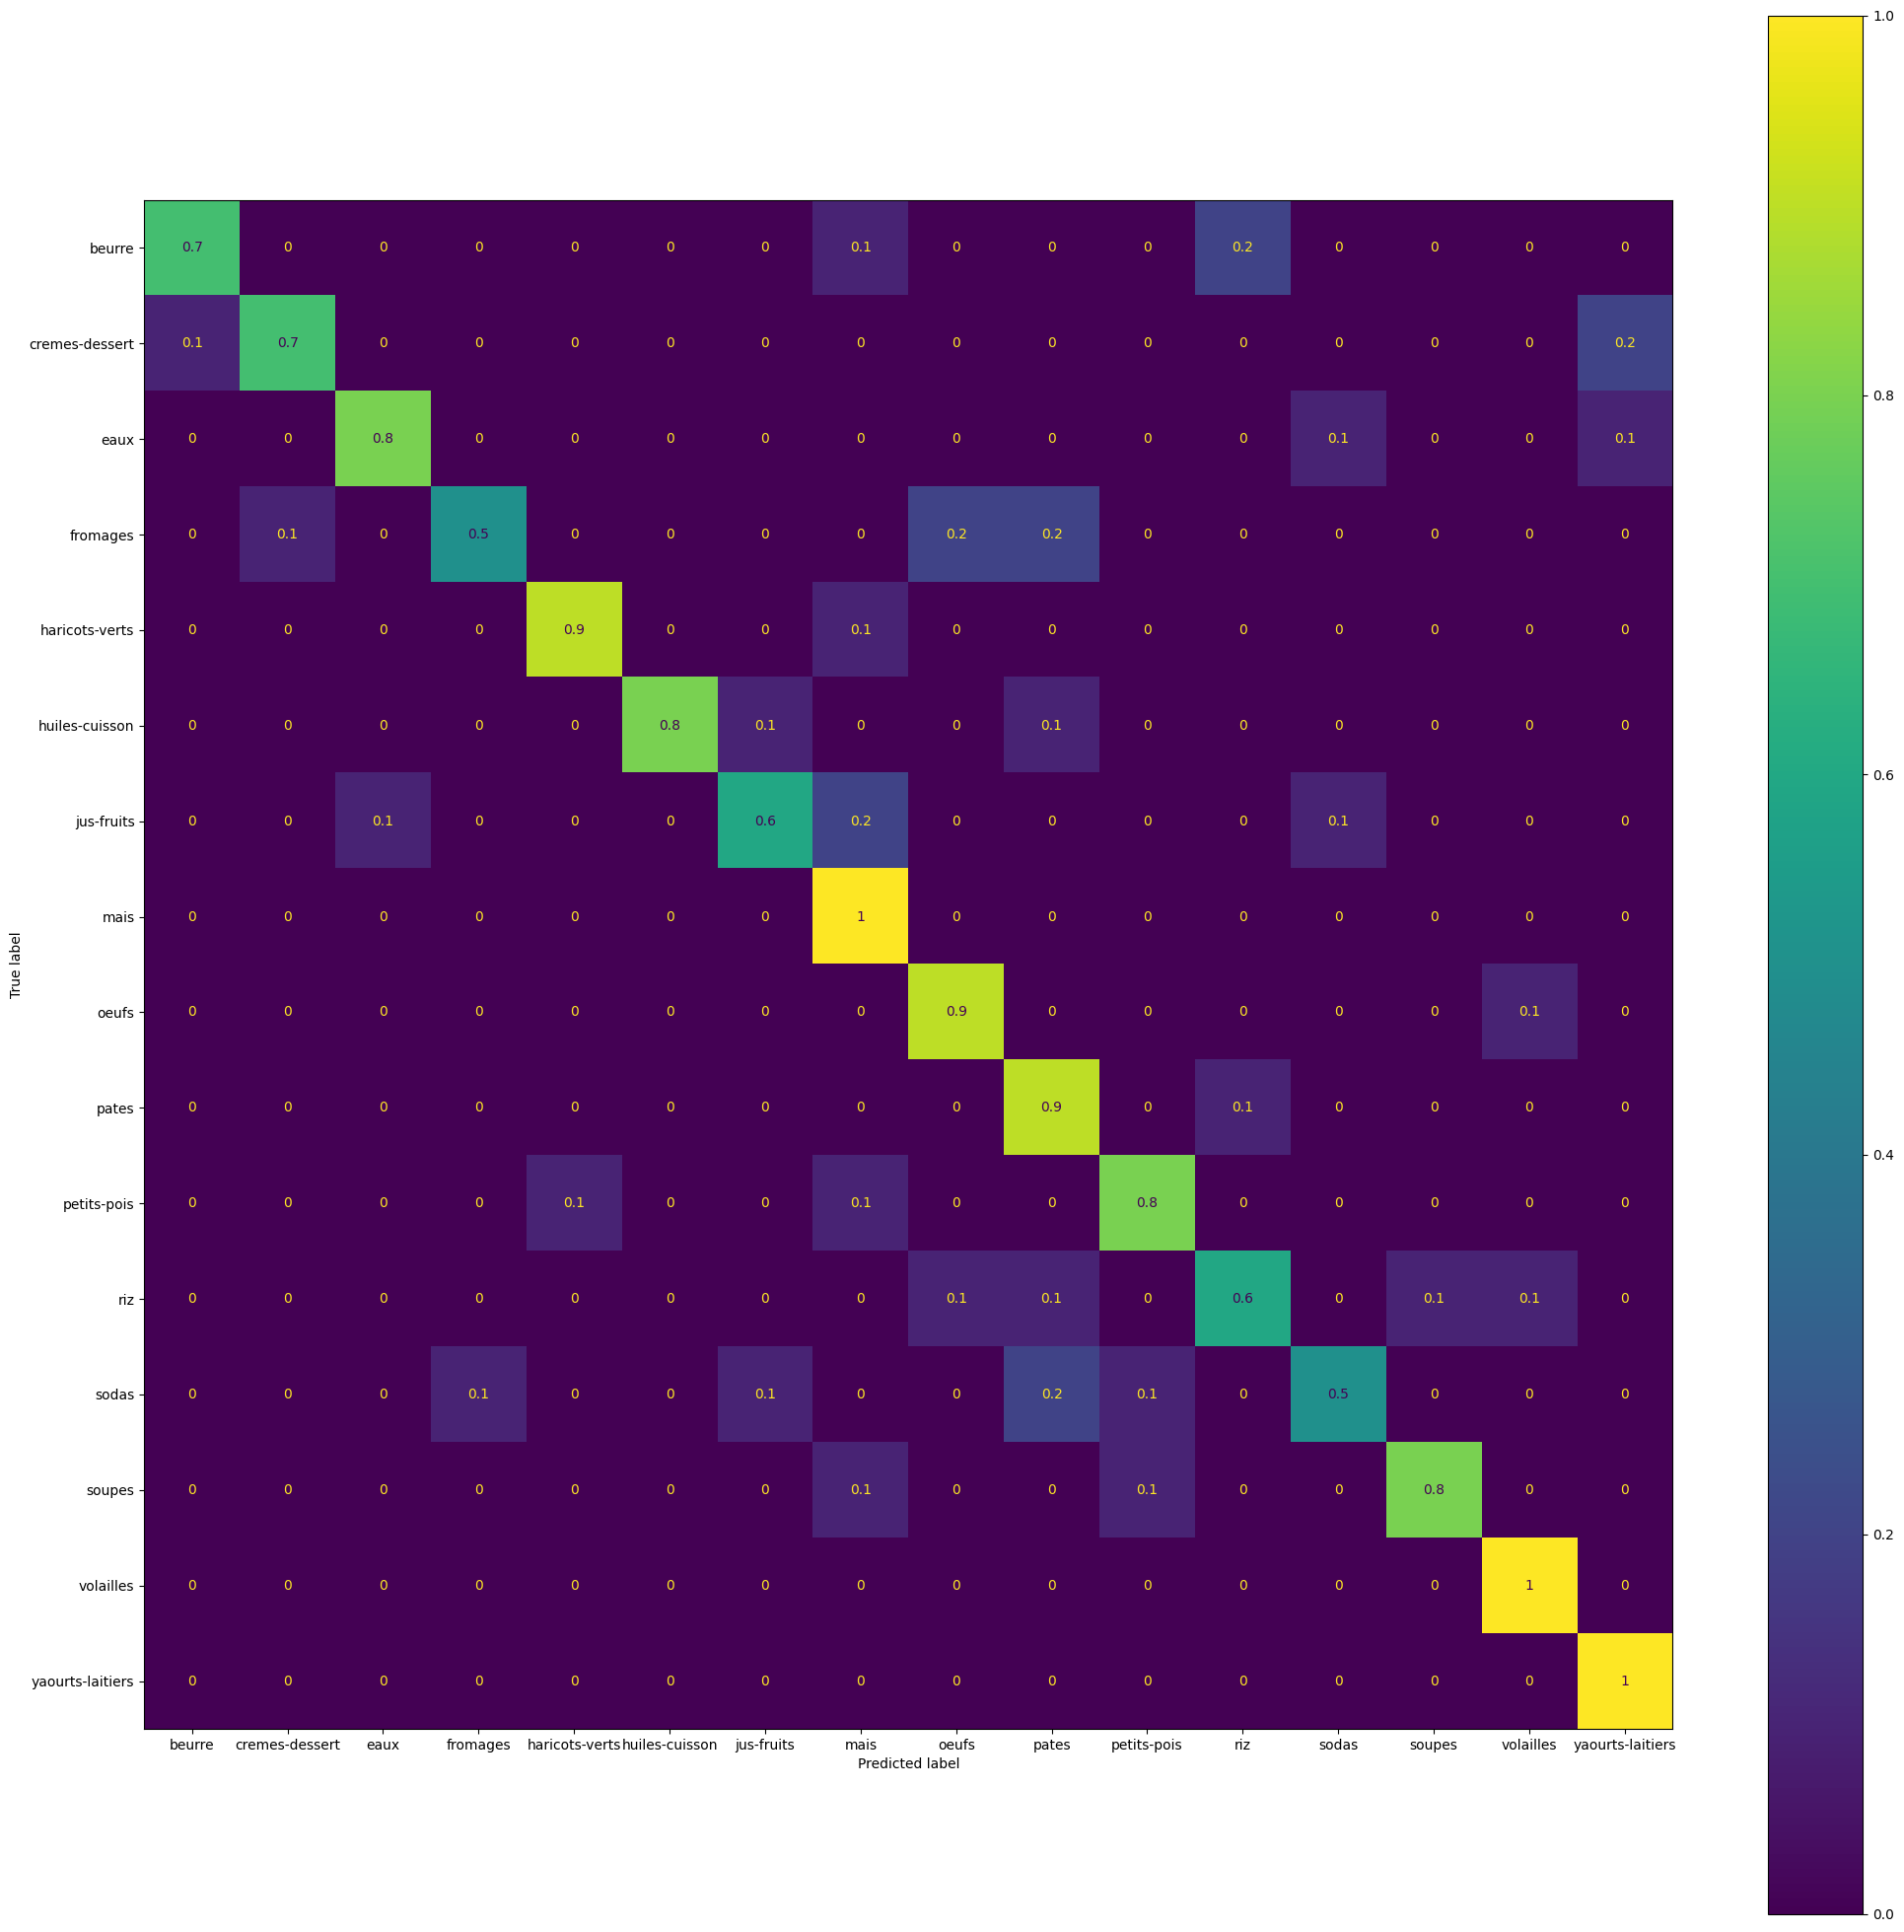

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(x_test), axis=-1)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

fig, ax = plt.subplots(figsize=(25,25))
disp.plot(ax=ax)
plt.show()

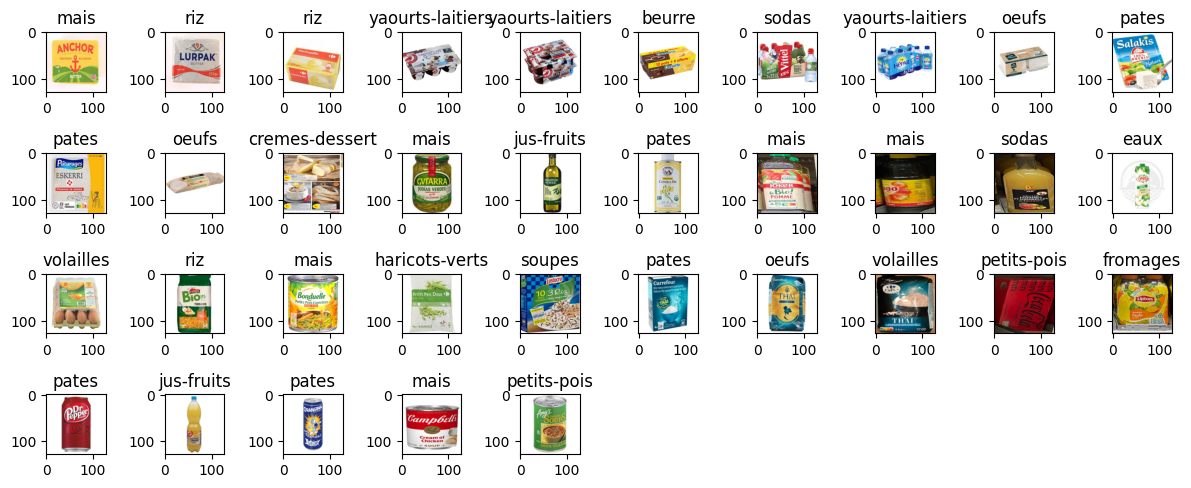

In [18]:
j = 1

plt.figure(figsize=(12, 12))
for i, label in enumerate(y_test):
  if label != y_pred[i]:
    plt.subplot(10, 10, j)
    image = x_test[i]
    plt.title(CLASSES[y_pred[i]])
    plt.imshow(image)
    j = j + 1

plt.tight_layout()
plt.show()